In [0]:
DRIVE = True

## Imports

In [2]:
# Basic imports ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf

# Keras / sklearn ---
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential, Model, clone_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

# Misc ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

! pip install ipython-autotime
%load_ext autotime

tf.enable_eager_execution()

if DRIVE:
    import os
    from google.colab import drive
    drive.mount('drive')
    os.chdir("drive/My Drive/SAM/7-projet")

# Self ---
import sys

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './scripts')

import msdi_text
import msdi_io
import img_deep_loader as img_loader

df = msdi_io.get_msdi_dataframe()

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=3a678b69eb9dfd36268e79efa4a64d17657e89d6985c9ff28ff1d5721ca598b0
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


## Models

In [3]:
def text_model(load_path):
    num_filters = 32
    kernel_size = 3
    embedding_dim = 50
    maxlen = 100
    vocab_size = 5000
    
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=vocab_size))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(15, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[AUC(name='auc')])
    model.load_weights(load_path)
    return model

def image_model(load_path):
  res = ResNet50(weights='imagenet', include_top = False, 
               input_shape=(200, 200, 3), pooling="avg")

  output = res.get_layer('avg_pool').output
  output = Dense(15, activation='sigmoid')(output) # your newlayer Dense(...)
  model = Model(res.input, output)


  opt = Adam(lr=10**-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(loss='categorical_crossentropy', optimizer=opt,
                metrics=[AUC(name='auc')])
  
  model.load_weights(load_path)
  return model
  
def sound_model():
  sound = Sequential()
  sound.add(Activation('linear', input_shape=(2048,)))
  sound.add(Dense(15, activation='softmax'))

  sound.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[AUC(name='auc')])
  return sound

time: 21.5 ms


In [4]:
class VotingClassifier:
  def __init__(self, NN_list):
    self.NN_list = NN_list
  
  def predict(self, entries, as_label=False):
    res_NN = []
    res = np.zeros((len(entries[0]), 15))
    for i in range(len(self.NN_list)):
      res_NN += [self.NN_list[i].predict(entries[i])]
    
    for dum in range(len(entries[0])):
      res_vec = np.zeros(15)
      for i in range(len(self.NN_list)):
        res_vec += res_NN[i][dum]
      res[dum] = res_vec
    if as_label:
      return msdi_io.dummies_to_labels(res)
    return res

  def accuracy(self, X, y):
    labels = self.predict(X, as_label=False)
    score = 0.0
    for i in range(len(y)):
      if y[i].argmax() == labels[i].argmax():
        score += 1.0
    return score / len(y)

time: 10.3 ms


In [5]:
def merged_model(nn_txt, nn_img):
  img = clone_model(nn_img)
  img.layers.pop()
  for layer in img.layers:
    layer.trainable = False

  txt = clone_model(nn_txt)
  txt.layers.pop()
  for layer in txt.layers:
    layer.trainable = False
  
  sound = Sequential()
  sound.add(Activation('linear', input_shape=(2048,)))

  mergedOut = Concatenate()([img.output, txt.output, sound.output])
  mergedOut = Flatten()(mergedOut)    
  mergedOut = Dense(256, activation='relu')(mergedOut)
  mergedOut = Dropout(.5)(mergedOut)
  mergedOut = Dense(128, activation='relu')(mergedOut)
  mergedOut = Dropout(.35)(mergedOut)

  # output layer
  mergedOut = Dense(15, activation='softmax')(mergedOut)
  model = Model([img.input, txt.input, sound.input], mergedOut)

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[AUC(name='auc')])
  return model


time: 10.9 ms


# **Main**

In [7]:
X, y = msdi_io.get_all_data_with_labels(df, "./data", 10000)
print(type(X["train"]), len(X["train"]), len(X["train"][0]))

Loading lyrics ...Done.
0 % - 30 % - 50 % - 60 % - 80 % - Done.
<class 'list'> 3 3418
time: 38min 14s


In [8]:
txt_nn = text_model("./data/models/TextConvNet.h5")
img_nn = image_model("./data/models/ImageResNet.h5")
snd_nn = sound_model()

big_model = merged_model(txt_nn, img_nn)

big_model.fit(X["train"], y["train"], epochs=2) 

94773248/94765736 [==============================] - 8s 0us/step
Train on 3418 samples
Epoch 1/2
3418/3418 [==============================] - 22s 6ms/sample - loss: 1.8016 - auc: 0.8675
Epoch 2/2
3418/3418 [==============================] - 11s 3ms/sample - loss: 1.5593 - auc: 0.9050


time: 58.8 s


In [9]:
print("img", img_nn.evaluate(np.array(X["test"][0]), y["test"]))
print("txt", txt_nn.evaluate(np.array(X["test"][1]), y["test"]))
print("both", big_model.evaluate(X["test"], y["test"]))

669/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [10]:
# Impossible to predict without reshaping and chaning type
X_float = {}
for key in X.keys():
  X_float[key] = X[key]
  X_float[key][0] = X_float[key][0].reshape((len(X_float[key][0]), 200, 200, 3)).astype(float)

time: 6.46 s


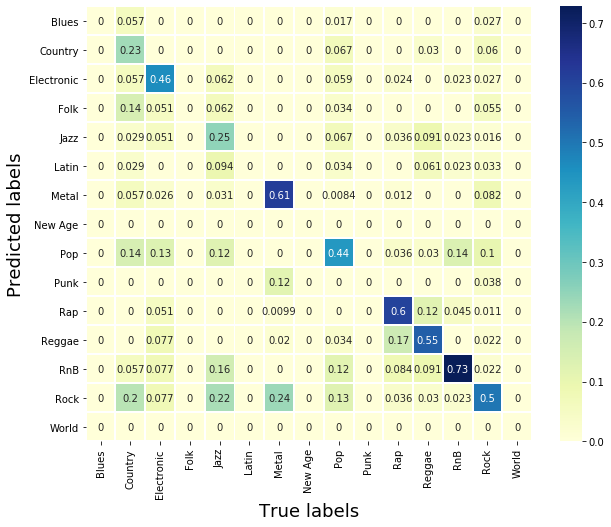

time: 3.77 s


In [11]:
preds = np.argmax(big_model.predict(X_float["test"]), axis=1)
# trues = np.argmax(y["test"], axis=1)

trues = np.argmax(y["test"], axis=1)


import seaborn as sns

from tensorflow.python.ops.metrics_impl import _streaming_confusion_matrix


def display_confusion_matrix(true_values, pred_values, labels):
    """
    to improve with totals
    https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
    """
    # calculate the confusion matrix with tensorflow function
    confusion_matrix = tf.math.confusion_matrix(
        true_values, pred_values, num_classes=len(labels)
    )
    confusion_matrix = np.array(confusion_matrix)

    # transform the confusion matrix to pandas dataframe to ease usage
    confusion_matrix = pd.DataFrame(
        confusion_matrix,
        index=[label for label in labels],
        columns=[label for label in labels]
    )

    for col in confusion_matrix.columns:
      if confusion_matrix[col].sum() > 0:
        confusion_matrix[col]  /= confusion_matrix[col].sum()
    
    # calculate a mask to display only the bottom triangle with diagonal
    mask = np.ones_like(confusion_matrix)
    mask[np.tril_indices_from(mask)] = False
    
    # display it !
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        mask=None,
        annot=True,
        linewidths=1,
        linecolor="white",
        cmap="YlGnBu"
    )
    plt.xlabel("True labels", fontsize=18)
    plt.ylabel("Predicted labels", fontsize=18)
    plt.show()
    return  confusion_matrix
    # histogram of accuracy per class
    # TODO

cm = display_confusion_matrix(trues, preds, msdi_io.get_label_list())

In [12]:
snd_nn.fit(X["train"][2], y["train"], epochs=2)
print(snd_nn.evaluate(X["test"][2], y["test"]))

Train on 3418 samples
Epoch 1/2
3418/3418 [==============================] - 1s 223us/sample - loss: 1.8699 - auc: 0.8761
Epoch 2/2
3418/3418 [==============================] - 0s 118us/sample - loss: 1.4994 - auc: 0.9179
669/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

train
3418/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

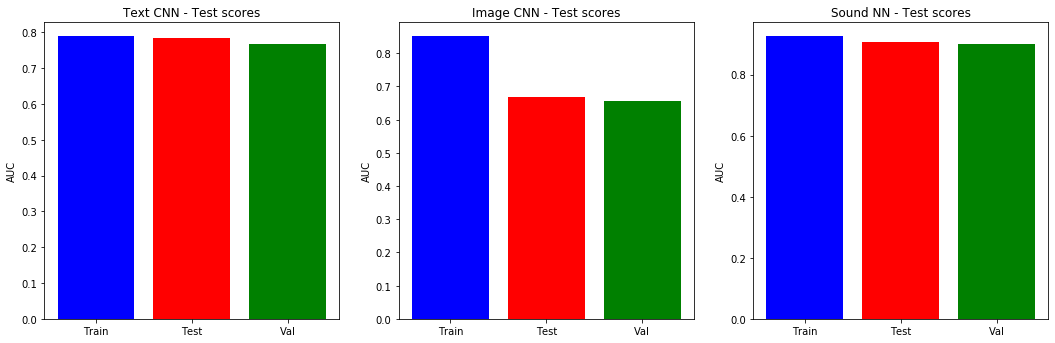

time: 16.8 s


In [13]:
txthist= []
imghist= []
sndhist = []
for key in X.keys():
  print(key)
  txthist.append(txt_nn.evaluate(X[key][1], y[key])[1])
  imghist.append(img_nn.evaluate(X_float[key][0], y[key])[1])
  sndhist.append(snd_nn.evaluate(X_float[key][2], y[key])[1])


colors = ["b", "r", "g"]
lbls = ["Train", "Test", "Val"]
plt.subplot(231)
plt.title("Text CNN - Test scores")
plt.ylabel("AUC")
plt.bar([0, 1, 2], txthist, tick_label=lbls, color=colors)
plt.subplot(232)
plt.title("Image CNN - Test scores")
plt.ylabel("AUC")
plt.bar([0, 1, 2], imghist, tick_label=lbls, color=colors)
plt.subplot(233)
plt.title("Sound NN - Test scores")
plt.ylabel("AUC")
plt.bar([0, 1, 2], sndhist, tick_label=lbls, color=colors)

fig = plt.gcf()
fig.set_size_inches(18, 12)
plt.show()

In [14]:
clf = VotingClassifier([txt_nn, img_nn])

print(clf.accuracy(X["test"], y["test"]))


# print(clf.predict([X_text[0:10], X_img[0:10]], as_label=True))
# print(img_loader.dummies_to_labels(y[0:10]))


ValueError: ignored

time: 495 ms
